<a href="https://colab.research.google.com/github/aletbm/HuggingFace_AI_Agent_FinalProject/blob/main/HF_Final_Project_AI_Agent_Alexander_Daniel_Rios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face Agent Course - Final Project - By [Alexander Daniel Rios](https://linktr.ee/aletbm)
<img src="https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit4/thumbnail.jpg">

# Clone the HF Space

In [ ]:
!git clone https://huggingface.co/spaces/AleTBM/AI_Agent

Cloning into 'AI_Agent'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 306 (delta 112), reused 0 (delta 0), pack-reused 115 (from 1)
Receiving objects: 100% (306/306), 269.76 KiB | 10.79 MiB/s, done.
Resolving deltas: 100% (174/174), done.


# Requirements

In [ ]:
%cd AI_Agent

/content/AI_Agent


In [ ]:
%%writefile requirements.txt

gradio
requests
langgraph
langchain
langchain-huggingface
langchain-community
langchain-experimental
langchain-litellm
litellm==1.67.0
unstructured[pdf]
duckduckgo-search
playwright
openai-whisper
wikipedia
arxiv
yt_dlp
pyld
docx2txt
openpyxl
pymupdf
pdfplumber
biopython
qwen-vl-utils[decord]==0.0.8
python-pptx
ratelimit
tenacity

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 14.5

# Log in HF

In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get('HF_TOKEN'))

# Environment variables

In [ ]:
with open(".env", "w") as env:
    env.write(f"SPACE_HOST={userdata.get('SPACE_HOST')}\n")
    env.write(f"SPACE_ID={userdata.get('SPACE_ID')}\n")
    env.write(f"GEMINI_API_KEY_1={userdata.get('GOOGLE_API_KEY_1')}\n")
    env.write(f"GEMINI_API_KEY_2={userdata.get('GOOGLE_API_KEY_2')}\n")
    env.write(f"GEMINI_API_KEY_3={userdata.get('GOOGLE_API_KEY_3')}\n")
    env.write(f"USER_AGENT=MyAgent\n")

#Loading GAIA files for validation and test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
gaia_files = "/content/drive/MyDrive/GAIA/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tools

In [ ]:
%%writefile tools.py

import os
import requests
import tempfile
from langchain.docstore.document import Document
from langchain.tools import Tool, StructuredTool, tool
from typing import Tuple, List
from langchain_core.messages import AIMessage
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain_community.agent_toolkits.playwright.toolkit import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langchain_community.document_loaders.wikipedia import WikipediaLoader
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_community.document_loaders.arxiv import ArxivLoader
from langchain_community.document_loaders.text import TextLoader
from langchain_community.document_loaders.word_document import Docx2txtLoader
import yt_dlp
import json
from Bio.PDB import PDBParser
import pandas as pd
from openpyxl import load_workbook
import math
import pdfplumber
from pptx import Presentation
import zipfile
from ratelimit import limits, sleep_and_retry
from tenacity import retry, wait_exponential, stop_after_attempt, retry_if_exception_type
from duckduckgo_search.exceptions import DuckDuckGoSearchException
from duckduckgo_search import DDGS
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import whisper

model_whisper = whisper.load_model("base")
model_image = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor_image = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

@tool
def add(a: str, b: str) -> str:
    """Adds two numbers provided as strings and returns the result as a string."""
    return str(float(a) + float(b))

@tool
def subtract(a: str, b: str) -> str:
    """Subtracts the second number from the first, both provided as strings, and returns the result as a string."""
    return str(float(a) - float(b))

@tool
def multiply(a: str, b: str) -> str:
    """Multiplies two numbers provided as strings and returns the result as a string."""
    return str(float(a) * float(b))

@tool
def divide(a: str, b: str) -> str:
    """Divides the first number by the second, both provided as strings, and returns the result as a string. The divisor must not be zero."""
    return str(float(a) / float(b))

@tool
def power(a: str, b: str) -> str:
    """Raises the first number (base) to the power of the second number (exponent), both provided as strings, and returns the result as a string."""
    return str(float(a) ** float(b))

@tool
def square_root(a: str) -> str:
    """Calculates the square root of a number provided as a string and returns the result as a string. The number must be non-negative."""
    return str(math.sqrt(float(a)))

@tool
def get_information_from_wikipedia(query: str) -> str:
    """
    Search for relevant Wikipedia pages based on a user query and return their URLs.

    This tool uses WikipediaLoader to retrieve up to 10 Wikipedia articles related to the input query.
    The output consists of a formatted list of URLs pointing to these articles. These URLs can be used
    by web automation tools or agents to navigate, scrape, and extract valuable information such as
    text, tables, infoboxes, images, and references that may help answer the user's question.

    Args:
        query (str): A user-provided search query.

    Returns:
        str: A formatted explanation with a list of Wikipedia URLs related to the query.
    """
    search_docs = WikipediaLoader(query=query, load_max_docs=10).load()
    print(search_docs)
    content = '\n\n'.join([f"{i}. Title: {doc.metadata['title']}\nSummary: {doc.metadata['summary']}\nSource: {doc.metadata['source']}\n" for i, doc in enumerate(search_docs)])

    return f"""Wikipedia search completed for query: "{query}".

You must now browse the following Wikipedia pages to extract detailed information. Use `navigate_browser` to explore each URL:

Relevant Wikipedia searches:
{content}

Instructions:
- Visit each URL using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

@tool
def get_information_from_arxiv(query: str) -> str:
    """
    Searches the arXiv database for academic papers related to a given query and returns up to 3 relevant results,
    including source metadata and a preview of each paper's content.

    This function queries the arXiv database for papers matching the provided search term. It retrieves up to 3 papers
    with content limited to 10,000 characters each. The results are formatted in XML-like structure with metadata
    such as the title, authors, and page number (if available).

    Args:
        query (str): The search term or topic to query on arXiv (e.g., "machine learning").

    Returns:
        str: A formatted string containing the metadata (title, authors, page number) and content preview
             for each of the top 3 relevant papers found on arXiv.
    """
    search_docs = ArxivLoader(query=query, load_max_docs=3, doc_content_chars_max=10000).load()
    content = ""
    for doc in search_docs:
        content += f"Title: {doc.metadata['Title']}\n"
        content += f"Authors: {doc.metadata['Authors']}\n"
        content += f"Summary: {doc.metadata['Summary']}\n"
        content += f"Published: {doc.metadata['Published']}\n\n"

    return f"""Arxiv search completed for query: "{query}".

Relevant Arxiv papers:
{content}

Instructions:
- Search the paper link throught it's title.
- Visit each URL using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

@tool
def get_web_page(url: str) -> str:
    """
    Use this to extract text from basic HTML pages. Works well for static websites without JavaScript.

    This function retrieves the content of a webpage at the specified URL and extracts all the visible text.

    Args:
        url (str): The URL of the public webpage to fetch (e.g., "https://example.com").

    Returns:
        str: A string containing the visible text content extracted from the webpage.

    Example:
        url = "https://en.wikipedia.org/wiki/Python_(programming_language)"
        page_text = get_web_page(url)
        print(page_text)

    In this example, the function will return the visible text from the Wikipedia page about "Python programming language",
    excluding JavaScript-generated or hidden content, formatted as plain text.
    """
    loader = WebBaseLoader(url)
    docs = loader.load()
    content = "\n\n".join([doc.page_content for doc in docs])
    return f"""The web page content is:

{content}

Instructions:
If the information is not sufficient:
- Visit the URL {url} using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

def download_video_from_youtube(url, tempdirname):
    """
    Downloads the best quality video from YouTube (MP4 format) and saves it in the specified directory.

    This function fetches the video from the provided YouTube URL, ensuring that the video format is MP4 with a
    resolution of at least 1080p. It also downloads subtitles if available, saving them in English as SRT files.

    Args:
        url (str): The YouTube video URL to download (e.g., "https://www.youtube.com/watch?v=example").
        tempdirname (str): The directory where the downloaded video and subtitles will be saved.

    Returns:
        str: The path to the downloaded video file (MP4 format).

    Example:
        url = "https://www.youtube.com/watch?v=example"
        tempdirname = "/tmp/videos"
        video_filepath = download_video_from_youtube(url, tempdirname)
        print(video_filepath)

    In this example, the function will download the best quality video and subtitles from the given YouTube URL
    and save them in the specified directory.
    """

    ydl_opts = {
        'format': '(bestvideo[width>=1080][ext=mp4]/bestvideo)+bestaudio/best', #Ensures best settings
        'writesubtitles': True, #Adds a subtitles file if it exists
        'writeautomaticsub': True, #Adds auto-generated subtitles file
        'subtitle': '--write-sub --sub-lang en', #writes subtitles file in english
        'subtitlesformat':'srt', #writes the subtitles file in "srt" or "ass/srt/best"
        'skip_download': False, #skips downloading the video file
        "merge_output_format": "mp4",
        'outtmpl':f"{tempdirname}/%(title)s.%(ext)s",
        'quiet': True,
        'cookiefile': "./cookies.txt"
        }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        video_title = info_dict.get('title', None)
        filepath = ydl.prepare_filename(info_dict)
    print(f"Download {filepath.split('/')[-1]} Successful!")
    return filepath

def download_audio_from_youtube(url, tempdirname):
    """
    Downloads the best quality audio (MP3 format) from a YouTube video and saves it in the specified directory.

    This function fetches the audio from the provided YouTube URL in the best available format and saves it
    as an MP3 file. It does not download the video.

    Args:
        url (str): The YouTube video URL to extract audio from (e.g., "https://www.youtube.com/watch?v=example").
        tempdirname (str): The directory where the audio file will be saved.

    Returns:
        str: The path to the downloaded audio file (MP3 format).

    Example:
        url = "https://www.youtube.com/watch?v=example"
        tempdirname = "/tmp/audio"
        audio_filepath = download_audio_from_youtube(url, tempdirname)
        print(audio_filepath)

    In this example, the function will download the best quality audio (MP3) from the YouTube URL
    and save it in the specified directory.
    """

    ydl_opts = {
        'extract_audio': True,
        'format': 'bestaudio',
        'outtmpl': f"{tempdirname}/%(title)s.mp3",
        'quiet': True,
        'cookiefile': "./cookies.txt"
        }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        audio_title = info_dict.get('title', None)
        filepath = ydl.prepare_filename(info_dict)
    print(f"Download {filepath.split('/')[-1]} Successful!")
    return filepath

def download_youtube_data(url: str) -> str:
    """
    Downloads the description and comments of a YouTube video using the yt-dlp Python API.

    Args:
        url (str): The URL of the YouTube video.

    Returns:
        str: File paths and summary of downloaded content.
    """
    ydl_opts = {
        'quiet': True,
        'extract_flat': False,
        'skip_download': True,
        'getcomments': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=False)

        description = info.get("description", "No description found.")

        comments = info.get("comments", [])
        comment_texts = [c["text"] for c in comments if "text" in c]

        return (
            f"Downloaded video data:\n\n"
            f"Description: {description}\n"
            f"Comments: {comment_texts}\n"
        )

    except Exception as e:
        return f"Error extracting video data: {str(e)}"

@tool
def get_information_from_youtube(url: str) -> str:
    """
    Downloads a YouTube video, extracts the audio, and returns a transcription of the audio.

    This function first downloads the video and audio from the given YouTube URL. Then, it transcribes the
    speech from the audio file using a transcription service.

    Args:
        url (str): The YouTube video URL to download and transcribe (e.g., "https://www.youtube.com/watch?v=example").

    Returns:
        str: The transcription text of the audio content extracted from the YouTube video.

    Example:
        url = "https://www.youtube.com/watch?v=example"
        transcription = get_information_from_youtube(url)
        print(transcription)

    In this example, the function will download the video and audio from YouTube, extract the audio, and
    return a transcription of the spoken content in the video.
    """

    tempdirname = tempfile.TemporaryDirectory()
    video_filepath = download_video_from_youtube(url, tempdirname)
    audio_filepath = download_audio_from_youtube(url, tempdirname)
    youtube_data = download_youtube_data(url)

    return youtube_data + get_information_from_audio.invoke(audio_filepath)

@tool
def get_information_from_audio(filepath: str) -> str:
    """
    Transcribes speech from an audio file into text using a speech-to-text model.

    This function takes an audio file and converts the spoken content into written text using a speech-to-text model.
    It is useful when you need to extract information from voice recordings.

    Args:
        filepath (str): The path to the audio file (e.g., ".wav", ".mp3", etc.).
                         The file should contain spoken content to be transcribed.

    Returns:
        str: The transcribed text from the audio file.

    Example:
        filepath = "/path/to/audiofile.wav"
        transcription = get_information_from_audio(filepath)
        print(transcription)

    In this example, the function will transcribe the speech from the specified audio file and return the
    transcribed text that can be further analyzed or used in other processes.
    """
    result = model_whisper.transcribe(filepath)
    return f"""Transcription of audio file:

{result['text']}

Please verify this information by cross-checking with reliable external sources such as web searches, Wikipedia, or other knowledge bases before finalizing your response.
If necessary, supplement the transcription with additional relevant information to ensure completeness and accuracy."""

@tool
def get_information_from_pdf(file_path: str) -> str:
    """
    Extracts structured text content from a PDF file.

    This function reads the content of a PDF document located at the specified file path and extracts the text
    from each page. The text is returned as a single string, with the order of pages preserved.

    Args:
        file_path (str): The local path to the PDF file to be processed (e.g., "/path/to/document.pdf").

    Returns:
        str: A single string containing the combined text extracted from all pages of the PDF.
             The text is ordered by the pages as they appear in the document.

    Example:
        file_path = "/path/to/document.pdf"
        extracted_text = get_information_from_pdf(file_path)
        print(extracted_text)

    In this example, the function will extract all text content from the PDF document,
    maintaining the page order, and return it as one continuous string.
    """

    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            content = page.extract_tables()
            if content and len(content) > 0:
                print("Tables were detected in the PDF.")
            else:
                print("No tables were detected in the PDF..")
                loader = PyPDFLoader(file_path = file_path)
                documents = loader.load()
                content = '\n'.join([doc.page_content for doc in documents])

    return f"""The PDF file content:

{content}

Use this data to answer the question or perform any required analysis.
Remember, you can use all available tools to supplement with additional relevant information."""

@tool
def get_information_from_csv(file_path: str) -> str:
    """
    Loads a CSV file and returns a structured summary of its tabular content.

    This function reads the entire CSV file and returns a textual representation of the data
    intended for use by AI agents or downstream systems that operate on text-based tables.

    Args:
        file_path (str): The path to the CSV file to load.

    Returns:
        str: A formatted string containing the CSV content as a table under the label `data_table`,
             along with metadata such as the number of rows and columns.
    """
    df = pd.read_csv(file_path)

    return f"""You are given a table extracted from a CSV file with {df.shape[0]} rows and {df.shape[1]} columns.

You are given a table extracted from a CSV file.

- Columns: {df.columns.tolist()}
- Shape: {df.shape[0]} rows × {df.shape[1]} columns
- Missing values: {df.isna().sum().sum()} total

You must answer user questions using Python code with pandas-like logic. Perform all necessary computations, filtering, and aggregation using the Python interpreter tool.

This dataset may contain missing values. If necessary, handle them appropriately (e.g., by filtering or imputing them) before analysis."""

@tool
def get_information_from_excel(file_path: str) -> str:
    """
    Extracts data and, when available, background color metadata from an Excel file (.xlsx or .xls).

    This function handles both Excel formats:
    - For .xlsx: extracts the full table and cell background colors.
    - For .xls: extracts only the tabular data (background colors not supported).

    Args:
        file_path (str): Path to the Excel file (.xlsx or .xls).

    Returns:
        str: A detailed string containing:
            - Table data extracted from the first sheet.
            - If available, a matrix of background cell colors (hex format).
            - Summary about number of rows and columns.
    """
    ext = os.path.splitext(file_path)[-1].lower()

    if ext == ".xlsx":
        # Load with openpyxl to extract both data and colors
        workbook = load_workbook(file_path, data_only=True)
        sheet = workbook.active
        color_data = []

        for row in sheet.iter_rows():
            row_colors = []
            for cell in row:
                fill = cell.fill
                color = fill.start_color.rgb if fill and fill.start_color and fill.start_color.rgb else "None"
                row_colors.append(f"#{color}" if color != "None" else "None")
            color_data.append(row_colors)

        df = pd.read_excel(file_path, engine="openpyxl", header=None)
        return f"""You are given two tables extracted from an Excel file (.xlsx):

- `data_table` contains the content of each cell.
- `color_table` contains the background color of each cell in ARGB hex format (or "None" if not set).

"data_table": {df.values.tolist()}
"color_table": {color_data}

Both tables are the same size: {df.shape[0]} rows × {df.shape[1]} columns.
Use this data to analyze the spreadsheet and answer user questions."""

    elif ext == ".xls":
        # Load with xlrd (colors not supported)
        df = pd.read_excel(file_path, engine="xlrd", header=None)
        return f"""You are given a table extracted from an Excel file (.xls):

- Background color metadata is not available for .xls files.

"data_table": {df.values.tolist()}

The table has {df.shape[0]} rows × {df.shape[1]} columns.
Use this data to analyze the spreadsheet and answer user questions."""

    else:
        return "Unsupported file format. Please provide a .xls or .xlsx Excel file."

@tool
def get_information_from_xml(file_path: str) -> str:
    """
    Reads the contents of an XML file and returns it as plain text.

    This function loads and parses an XML file from the specified file path and returns
    its content as a plain text string. The text includes the structure and data contained
    within the XML, which can help in understanding the layout and details of the document.

    Args:
        file_path (str): The local path to the XML file (e.g., "/path/to/document.xml").

    Returns:
        str: A plain text representation of the XML file's contents, including its structure and data.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        xml_string = f.read()
        xml_string = xml_string.replace(">", ">\n")
        #data_dict = xmltodict.parse(xml_string)
        #pretty_json = json.dumps(data_dict, indent=2)
    return f"""You are given an XML document converted into JSON format:

{xml_string}

Use this to answer questions about the document's structure, contents, or metadata.
If relevant, identify key entities, attributes, or relationships. """

@tool
def get_information_from_json(file_path: str) -> str:
    """
    Loads and returns JSON content as a formatted string.

    This function opens a JSON file from the specified file path, loads its contents,
    and returns the entire JSON structure as a string. The data is formatted as valid JSON,
    which is helpful for examining structured data in key-value pairs.

    Args:
        file_path (str): The local path to the .json file (e.g., "/path/to/data.json").

    Returns:
        str: A stringified version of the entire JSON data, formatted as a valid JSON string.

    Example:
        file_path = "/path/to/data.json"
        json_content = get_information_from_json(file_path)
        print(json_content)

    In this example, the function will:
    - Open the specified JSON file.
    - Load and parse its contents.
    - Return the data as a JSON-formatted string that can be used for further processing or analysis.
    """

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return f"""The content of the JSON/JSON-LD file has been successfully extracted:

{json.dumps(data, indent=2)}

Instruction for the agent:

1. Scan the JSON content for any fields containing URLs (e.g., 'url', '@id', 'source', 'link').
2. For each URL found, you must explore the associated website as thoroughly as possible.
   - Do not limit the navigation to the landing page.
   - Recursively follow internal links, sections, and dynamically loaded content.
   - Extract valuable text, metadata, references, and any structured content.
3. Prioritize using the tools in the following order:

TOOL PRIORITY ORDER:
1. `navigate_browser`– Use for navigating to external websites.
2. `get_web_page` – Use for static HTML websites without JavaScript.
3. `duckduckgo_web_search_run` – Use when a URL is missing or additional context is needed.

If the JSON contains names, terms, or identifiers without direct links, consider searching Wikipedia or arXiv for background knowledge.

Important:
You must fully explore the websites found in the JSON, including internal resources and linked data. Don't stop at the home or landing page."""

@tool
def get_information_from_pdb(file_path: str) -> str:
    """
    Extracts 3D structural data from a PDB (Protein Data Bank) file.

    This function parses a PDB file and generates a human-readable summary of its
    molecular structure, including information about chains, residues, and atom positions
    in 3D space. The output is particularly useful for understanding the structural
    layout of proteins or other molecules stored in the PDB format.

    Args:
        file_path (str): The local path to the .pdb file (e.g., "/path/to/structure.pdb").

    Returns:
        str: A detailed, human-readable summary of the PDB file, listing the chains,
             residues, and atoms with their 3D coordinates.

    Example:
        file_path = "/path/to/structure.pdb"
        pdb_info = get_information_from_pdb(file_path)
        print(pdb_info)

    In this example, the function will:
    - Parse the PDB file located at the given path.
    - Extract information about chains, residues, and atoms, along with their coordinates in 3D space.
    - Return a summary of the molecular structure with the positions of atoms in x, y, and z coordinates.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("my_protein", file_path)

    info = []

    for model in structure:
        for chain in model:
            for residue in chain:
                res_info = f"Chain {chain.id} Residue {residue.resname} {residue.id[1]}:\n"
                for atom in residue:
                    coords = atom.get_coord()
                    res_info += f"  Atom {atom.name}: x={coords[0]:.2f}, y={coords[1]:.2f}, z={coords[2]:.2f}\n"
                info.append(res_info)

    return "\n".join(info)

@tool
def get_information_from_txt(file_path: str) -> str:
    """
    Extracts plain text content from a .txt file.

    This function loads the full textual content from a local .txt file and returns it
    as a single string. It preserves the original formatting and is useful for processing
    documents that contain unstructured or natural language text.

    Args:
        file_path (str): Absolute or relative path to the .txt file (e.g., "documents/file.txt").

    Returns:
        str: The complete plain text extracted from the file.

    Example:
        file_path = "notes/lecture.txt"
        text = get_information_from_txt(file_path)
        print(text)

    Use this tool when:
    - You need to read or analyze the full content of a text file.
    - The input is stored in a standard plain-text format (.txt).
    """
    loader = TextLoader(file_path)
    documents = loader.load()
    content = "\n".join([doc.page_content for doc in documents])
    return f"The TXT file content is:\n\n {content}"

@tool
def get_information_from_python(file_path: str) -> str:
    """
    Loads and returns the source code from a Python (.py) file.

    This function opens a local Python script from the specified file path, reads its entire
    source code, and returns it as a formatted string. It's useful for inspecting, analyzing,
    or executing the contents of Python files in later steps.

    Args:
        file_path (str): Absolute or relative path to the Python file (e.g., "scripts/my_script.py").

    Returns:
        str: The full Python source code from the file as a string.

    Example:
        file_path = "models/model_utils.py"
        code = get_information_from_python(file_path)
        print(code)

    Use this tool when:
    - You need to analyze or execute the contents of a Python script.
    - The input is a .py file and contains valid Python code.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        code = f.read()
    return f"""Python source code extracted from: {file_path}

{code}

Suggested next step:
If you want to analyze or run this code, use the python_code_executor tool and pass the code directly as input.
"""

@tool
def get_information_from_docx(file_path: str) -> str:
    """
    Extracts text content from a Microsoft Word (.docx) file.

    This function reads a .docx file from the specified file path and returns all
    human-readable text as a single string, preserving the logical order of the document.
    It is useful when you need to analyze or summarize documents created in Microsoft Word.

    Args:
        file_path (str): Full or relative path to the .docx file (e.g., "reports/report.docx").

    Returns:
        str: The complete extracted text from the Word document.

    Example:
        file_path = "contracts/agreement.docx"
        text = get_information_from_docx(file_path)
        print(text)

    Use this tool when:
    - The input file is a .docx Word document.
    - You want to extract the entire textual content for processing, querying, or summarization.
    """
    loader = Docx2txtLoader(file_path)
    documents = loader.load()
    return "\n".join([doc.page_content for doc in documents])

@tool
def get_information_from_pptx(file_path: str) -> str:
    """
    Extracts all text from a PowerPoint (.pptx) file slide by slide.

    Use this tool when:
    - You need to read and analyze the text content of a presentation.
    - You want to understand slide structure or extract meaningful information from slides.

    Args:
        file_path (str): Path to the .pptx file.

    Returns:
        str: Extracted text content from the presentation.
    """
    prs = Presentation(file_path)
    all_text = []

    for i, slide in enumerate(prs.slides):
        slide_text = []
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                slide_text.append(shape.text.strip())
        if slide_text:
            all_text.append(f"- Slide {i + 1}\n" + "\n".join(slide_text))
    all_text = '\n\n'.join(all_text)
    return f"""The PPTX file content is:

{all_text}

You can use this information to answer the user question.
"""

@tool
def get_information_from_image(file_path: str, question: str) -> str:
    """
    Performs visual question answering (VQA) on an image file.

    This tool allows the agent to reason about the contents of an image. It takes a path to an image file
    and a natural language question, processes the image and text using a vision-language model,
    and returns a text-based answer derived from the visual information.

    Args:
        file_path (str): Path to the image file (e.g., "images/photo.png").
        question (str): Natural language question to ask about the image (e.g., "What is the person holding?").

    Returns:
        str: Answer generated by the vision-language model based on the image and the question.

    Example:
        answer = get_information_from_image("cat.jpg", "What color is the cat?")
        print(answer)

    Use this tool when:
    - You need to analyze or describe visual content in an image.
    - The user asks a question involving a photo, diagram, chart, screenshot, or other image file.
    - Visual reasoning is required to answer the question.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": file_path,
                },
                {"type": "text", "text": question},
            ],
        }
    ]

    text = processor_image.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor_image(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = model_image.generate(**inputs, max_new_tokens=1024)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor_image.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return f"VISUAL ANSWER: {output_text}"


@tool
def get_all_files_from_zip(file_path: str) -> Tuple[List[str], str]:
    """
    Extracts all files from a ZIP archive to a temporary directory and returns their paths.

    Args:
        file_path (str): Path to the .zip archive.

    Returns:
        Tuple[List[str], str]:
            - A list of full paths to the extracted files.
            - A summary string indicating how many files were extracted.
    """
    files = []
    temp_dir = tempfile.gettempdir()
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(temp_dir)
    zip_files = zip_ref.namelist()
    for filename in zip_ref.namelist():
        temp_file_path = os.path.join(temp_dir, filename)
        files.append(temp_file_path)

    prompt = f"The ZIP file contains {len(files)} file(s)."
    return files, prompt

@retry(
    wait=wait_exponential(multiplier=1, min=15, max=60),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(DuckDuckGoSearchException)
)
@sleep_and_retry
@limits(calls=1, period=5)
def get_dgg_search(query: str, mode: str):
    with DDGS() as ddgs:
        return ddgs.text(query, max_results=10)

def get_information_from_searches(query: str) -> str:
    """
    Perform a DuckDuckGo search and return a textual summary and structured top results with guidance for the agent.

    Args:
        query (str): The search query string.

    Returns:
        str: Combined summary and list of links with step-by-step instructions.
    """
    #text_summary = get_dgg_search(query, mode="run")
    structured_results = get_dgg_search(query, mode="results")

    if not structured_results or len(structured_results) == 0:
        structured_block = "No results found."
    else:
        structured_block = "\n\n".join([
            f"{i+1}. Title: {res.get('title', 'No title')}\n"
            f"Snippet: {res.get('body', 'No snippet')}\n"
            f"Link: {res.get('href', 'No link')}"
            for i, res in enumerate(structured_results)
        ])

    #text_block = text_summary if text_summary and len(text_summary) > 5 else "No summary available."

    return f"""DuckDuckGo Search Results for query: `{query}`

Top Search Results:
{structured_block}

Instructions for the Agent:
1. Snippets are only references; never extract or infer answers directly from them..
2. Use `navigate_browser` to open promising links.
   - Prioritize links whose titles or snippets closely match the key terms in the question.
   - Focus on extracting structured information like main content, tables, or lists.
3. If a page lacks sufficient data, explore internal links within that domain.
4. Combine information from multiple sources if needed to answer the original question accurately."""


search_tool = Tool(
    name="duckduckgo_search",
    func=get_information_from_searches,
    description=(
        "Use this tool to perform a live DuckDuckGo web search and retrieve a list of relevant links "
        "with snippets. Ideal for finding general information from public websites that are well indexed by DuckDuckGo.\n\n"
        "Limitations:\n"
        "- DuckDuckGo may not return results for sites like Google.\n"
        "Fallback Instructions:\n"
        "If this tool returns no useful information or fails to retrieve results:\n"
        "- Use `navigate_browser` to open relevant links or perform a direct search in a browser context.\n"
        "- Extract detailed information from the visited web pages, including main text, sidebars, and tables.\n"
        "- Explore internal links within the pages if needed to answer the question."
    )
)

def verbose_python_executor(code: str) -> str:
    """Executes Python code and returns both the code and the output."""
    tool = PythonREPLTool()
    result = tool.run(code)
    return f"Code executed:\n```python\n{code}\n```\n\nOutput:\n{result}"

python_tool = Tool(
    name="python_code_executor",
    func=verbose_python_executor,
    description=(
        "Use this tool to execute raw Python code.\n\n"
        "Input: A Python code snippet as a single string.\n\n"
        "Important:\n"
        "- This is NOT a remote API call. Do NOT include calls to `default_api`, `__arg1`, or any tool inside the code.\n"
        "- The code should be ready to run directly in Python, using standard libraries."
    )
)

def download_file_temp(url: str) -> str:
    """
    Downloads a file from the given URL and saves it into a temporary directory.

    Args:
        url (str): URL of the file to download.

    Returns:
        str: Path to the downloaded file or an error message.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        # Create a temporary directory
        temp_dir = tempfile.mkdtemp()

        # Extract filename from URL or fallback to a generic name
        filename = url.split("/")[-1] or "downloaded_file"

        # Full path for saving file
        file_path = os.path.join(temp_dir, filename)

        with open(file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        return f"File downloaded successfully and saved at {file_path}"
    except Exception as e:
        return f"Failed to download file: {e}"

download_tool = Tool(
    name="file_downloader_temp",
    func=download_file_temp,
    description="Downloads a file from a URL and saves it in a temporary folder."
)

# Create a Playwright browser instance
def initialize_web_tools():
    async_browser = create_async_playwright_browser()
    toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
    return toolkit.get_tools()

Overwriting tools.py


# Agent

In [ ]:
%%writefile agent.py

import os
import time
from langchain.tools import Tool, tool
from typing import Tuple, List
from typing_extensions import TypedDict, Annotated, Optional
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_litellm import ChatLiteLLM
import litellm
from IPython.display import Image, display
import asyncio
from google.api_core.exceptions import GoogleAPICallError
from tools import (search_tool,
                   download_tool,
                   get_web_page,
                   add,
                   subtract,
                   multiply,
                   divide,
                   power,
                   square_root,
                   python_tool,
                   get_information_from_wikipedia,
                   get_information_from_arxiv,
                   get_information_from_youtube,
                   get_information_from_python,
                   get_information_from_json,
                   get_information_from_audio,
                   get_information_from_xml,
                   get_information_from_docx,
                   get_information_from_txt,
                   get_information_from_pdf,
                   get_information_from_csv,
                   get_information_from_excel,
                   get_information_from_pdb,
                   get_information_from_image,
                   get_information_from_pptx,
                   get_all_files_from_zip)

DELAY = 5
RPM = 15
TIME_SLEEP = 60/RPM + DELAY

GEMINI_API_KEY_1 = os.getenv("GEMINI_API_KEY_1")
GEMINI_API_KEY_2 = os.getenv("GEMINI_API_KEY_2")
GEMINI_API_KEY_3 = os.getenv("GEMINI_API_KEY_3")

chat_model_1 = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0,
                         api_key=GEMINI_API_KEY_1,
                         max_retries=10,
                         verbose=True)

chat_model_2 = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0,
                         api_key=GEMINI_API_KEY_2,
                         max_retries=10,
                         verbose=True)

chat_model_3 = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0,
                         api_key=GEMINI_API_KEY_3,
                         max_retries=10,
                         verbose=True)

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    question: Optional[str]
    file_path: Optional[str]
    task_id: Optional[str]
    new_messages: Optional[int]
    final_answer: Optional[str]
    attempt: Optional[int]
    chat_model: Optional[int]

class MyAgent:
    def __init__(self, web_tools=None):
        print("MyAgent initialized.")

        self.chat_1 = chat_model_1
        self.chat_2 = chat_model_2
        self.chat_3 = chat_model_3

        self.tools = [search_tool,
                    download_tool,
                    get_web_page,
                    add,
                    subtract,
                    multiply,
                    divide,
                    power,
                    square_root,
                    get_information_from_wikipedia,
                    get_information_from_arxiv,
                    get_information_from_youtube,
                    python_tool,
                    get_information_from_json,
                    get_information_from_audio,
                    get_information_from_xml,
                    get_information_from_docx,
                    get_information_from_txt,
                    get_information_from_pdf,
                    get_information_from_csv,
                    get_information_from_excel,
                    get_information_from_pdb,
                    get_information_from_image,
                    get_information_from_pptx,
                    get_all_files_from_zip] + web_tools

        self.chat_with_tools_1 = self.chat_1.bind_tools(self.tools, verbose=True)
        self.chat_with_tools_2 = self.chat_2.bind_tools(self.tools, verbose=True)
        self.chat_with_tools_3 = self.chat_3.bind_tools(self.tools, verbose=True)
        self.chats = [self.chat_with_tools_1, self.chat_with_tools_2, self.chat_with_tools_3]

        self.builder = StateGraph(AgentState)
        self.builder.add_node("assistant", self.assistant)
        self.builder.add_node("tools", ToolNode(self.tools))
        self.builder.add_node("extract_data_from_file", self.extract_data_from_file)
        self.builder.add_node("postprocess", self.postprocess)

        self.builder.add_edge(START, "extract_data_from_file")
        self.builder.add_edge("extract_data_from_file", "assistant")
        self.builder.add_conditional_edges(
            "assistant",
            self.assistant_router,
            {
                "tools": "tools",
                "postprocess": "postprocess"
            }
        )
        self.builder.add_edge("tools", "assistant")
        self.builder.add_conditional_edges(
            "postprocess",
            self.answer_evaluation,
            {
                "RETRY": "assistant",
                "END": END
            }
        )

        self.agent = self.builder.compile()

    async def __call__(self, question: str, file_path: str, task_id: str) -> str:
        print("\033[1m\033[93m"+"="*150+"\033[0m")
        prompt = f"""You are a general AI assistant. You will receive a user question and extracted data from associated files.

Your primary goal is to be extremely careful, methodical, and evidence-based when analyzing the question and producing answers.

Follow this process strictly:

1. Analyze the user question:
   - Determine the exact required output type (number, string, list, etc).
   - Identify key entities, constraints, and any implicit requirements.

2. Do NOT rely on common knowledge, heuristics, or general assumptions:
   - For any classification task (e.g., botanical categories), you MUST verify each item explicitly against formal, authoritative sources.
   - Use online searches, databases, or reference tools to confirm the classification.
   - If verification is not possible due to tool limitations or lack of available sources:
     - Only then, you may deduce the answer based on structured, logical knowledge or definitions (e.g., taxonomy, anatomy, mathematics, etc.).
     - Check if the answer is explicitly present in the extracted data.
     - Do NOT rely on common knowledge, cultural conventions, popular usage, heuristics, or guesses.
     - Your deduction must be explainable based on first principles or formal definitions, and include explicit logical steps.

3. If tools are needed:
   - Devise a clear, step-by-step plan including:
     - Reasoning and sequence of tool usage.
     - Search queries tailored to find authoritative definitions or classifications.
     - Use a version of the question optimized for search engines (DuckDuckGo).
     - Use advanced search operators (site:, filetype:, inurl:) to target trusted sources.
   - Do not execute any tool until the entire plan is ready.

4. Search query rules:
   - Be keyword-focused (avoid full sentences).
   - Target reputable sources such as academic, botanical databases, government or educational sites.
   - Use advanced operators if helpful: `site:` for domains, `inurl:` for internal paths, `filetype:` for formats.
   - Avoid punctuation, commas, quotes, or special characters.
   - Cover multiple query angles if needed.

5. If a tool fails or yields poor results:
   - Reformulate the query with synonyms or add context.
   - Retry or switch to fallback tools.

6. Analyze all tool results carefully:
   - Extract explicit classification statements.
   - If multiple conflicting sources, prefer more authoritative or scientific references.
   - Exclude any item without clear, explicit verification.

7. Use the `navigate_browser` tool to read full pages. Don't use snippets since they are insufficient to answer the user question.

8. For any mathematical, algebraic, or list-processing tasks (e.g., sorting), use `python_code_executor`.
   - When sorting a list of strings alphabetically:
     - Perform a case-insensitive alphabetical sort using `sorted(list, key=lambda x: x.lower())`.
     - Preserve the original text and order formatting of each item — do not modify punctuation, grammar, or remove adjectives.
     - Return the result as a comma-separated list of strings, with exact original wording preserved.
   - When working with tables extracted from Excel files (`data_table`, `color_table`):
     - Use Pandas to structure the data as DataFrames and perform precise queries, filters, aggregations, comparisons, or transformations.
     - Ensure that each operation respects the original cell structure and types (text, numeric, empty).
     - Avoid assumptions — validate presence of values explicitly and handle missing or "None" cells cautiously.

9. Always double-check that your final answer fully respects all definitions and constraints specified by the user, especially when strict classification is demanded.

10. When extracting text from transcripts or documents:
   - Preserve the original wording exactly as it appears, except convert number words to digits.
   - Do NOT paraphrase, summarize, or alter expressions.
   - Do NOT remove adjectives, simplify phrases, or make any linguistic modifications.

11. When dealing with names, entities, or roles:
    - Pay close attention to context: distinguish between a person (e.g., actor) and the role they played (e.g., character).
    - If a question references both a person and their role, ensure the output matches exactly what the question asks for.
    - Do not confuse names of real people with names of characters, places, or concepts unless explicitly intended.

Throughout the process, prioritize precision, completeness, and correct interpretation of the user’s question.

YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma-separated list of numbers and/or strings.

If you are asked for a number:
- Don't use comma to write your number.
- Don't use units such as $ or percent sign unless specified otherwise.
- If the number ends in ".00", remove the decimal part and return only the integer (e.g., 89706.00 → 89706).
- If the number has non-zero decimal digits, leave it as is (e.g., 102.05 → 102.05).

If you are asked for a string:
- If it is a single word, capitalize it (e.g., "blue" → "Blue").
- If it is a name (person, city, etc.), capitalize each word (e.g., "john smith" → "John Smith").
- Do not use articles.
- Do not use abbreviations (e.g., for cities).
- Write the digits in plain text unless specified otherwise.

If you are asked for a comma-separated list:
- If the list contains names (e.g., people or places), capitalize each word in each name.
- If the list contains general objects (e.g., ingredients, things), use lowercase.
- For numbers, apply the rules above.
- The list must be correctly separated by commas and spaces.

Do NOT add a period at the end of the answer.

Report your thoughts, and finish your answer with the following template:
FINAL ANSWER: [YOUR FINAL ANSWER]

Example outputs:
- `FINAL ANSWER: Blue`
- `FINAL ANSWER: 102.05`
- `FINAL ANSWER: Paris, London, Madrid`
- `FINAL ANSWER: cheese, fresh lettuce, apple, banana`"""

        user_message = f"""Question: {question}
Filepath: {file_path}"""

        messages = [SystemMessage(content=prompt, name="SYSTEM"),
                    HumanMessage(content=user_message, name="USER")]

        response = await self.agent.ainvoke({"messages": messages,
                                             "question": question,
                                             "file_path": file_path,
                                             "task_id": task_id,
                                             "new_messages": 1,
                                             "chat_model": 0,
                                             "final_answer": "",
                                             "attempt": 0},
                                              {"recursion_limit": 100})

        print("\033[1m\033[93m"+"="*150+"\033[0m")
        return response['final_answer']

    async def call_chat(self, chat, state: AgentState, max_retries=5):
        for i in range(max_retries):
            try:
                return await chat.ainvoke(state["messages"])
            except litellm.InternalServerError:
                print(f"[Gemini] Overloaded (attempt {i+1}), retrying...")
                time.sleep(2 ** i)
        raise RuntimeError("Gemini failed after multiple retries")

    async def assistant(self, state: AgentState):
        new_messages = state["new_messages"]

        for i in reversed(range(1, new_messages+1)):
            print("\033[1m\033[92m"+"+"*150+"\033[0m")
            name = state["messages"][-i].name
            content = state["messages"][-i].content
            print(f'\033[1m\033[96m{name}\033[0m: {content if len(content) < 5000 else content[:5000]}')

        chat = self.chats[state["chat_model"]]
        result = await self.call_chat(chat=chat, state=state)

        state["chat_model"] += 1
        state["chat_model"] %= len(self.chats)

        result.name="ASSISTANT"
        await asyncio.sleep(TIME_SLEEP)

        print("\033[1m\033[92m"+"+"*150+"\033[0m")
        content = result.content[:-2] if result.content[-2:] == '\n\n' else result.content
        print(f'\033[1m\033[96m{result.name}\033[0m: {content}')
        state["new_messages"] = 1
        state["messages"].append(result)

        return state

    def extract_data_from_file(self, state: AgentState) -> str:
        path = state["file_path"]
        new_messages = state["new_messages"]
        prompt = ""
        messages = []

        if path and "." in path:
            ext = path.strip().split(".")[-1].lower()
            print(f"Extension detected: {ext}")

            if ext == "zip":
                files, prompt = get_all_files_from_zip(path)
                name = "get_all_file_from_zip"
                messages.append(AIMessage(content=prompt, name=name))
            else:
                files = [path]

            for file_path in files:
                ext = file_path.strip().split(".")[-1].lower()
                print(f"Extension detected: {ext}")

                prompt = f"Information extracted from {file_path}.\n\n"
                match ext:
                    case "csv":
                        content = get_information_from_csv.invoke(file_path)
                        name = "get_information_from_csv"
                    case "txt":
                        content = get_information_from_txt.invoke(file_path)
                        name = "get_information_from_txt"
                    case "pdf":
                        content = get_information_from_pdf.invoke(file_path)
                        name = "get_information_from_pdf"
                    case "json":
                        content = get_information_from_json.invoke(file_path)
                        name = "get_information_from_json"
                    case "jsonld":
                        content = get_information_from_json.invoke(file_path)
                        name = "get_information_from_json"
                    case "xml":
                        content = get_information_from_xml.invoke(file_path)
                        name = "get_information_from_xml"
                    case "pdb":
                        content = get_information_from_pdb.invoke(file_path)
                        name = "get_information_from_pdb"
                    case "mp3":
                        content = get_information_from_audio.invoke(file_path)
                        name = "get_information_from_audio"
                    case "m4a":
                        content = get_information_from_audio.invoke(file_path)
                        name = "get_information_from_audio"
                    case "docx":
                        content = get_information_from_docx.invoke(file_path)
                        name = "get_information_from_docx"
                    case "xlsx":
                        content = get_information_from_excel.invoke(file_path)
                        name = "get_information_from_excel"
                    case "xls":
                        content = get_information_from_excel.invoke(file_path)
                        name = "get_information_from_excel"
                    case "png":
                        content = get_information_from_image.invoke({"file_path": file_path, "question": state["question"]})
                        name = "get_information_from_image"
                    case "jpg":
                        content = get_information_from_image.invoke({"file_path": file_path, "question": state["question"]})
                        name = "get_information_from_image"
                    case "py":
                        content = get_information_from_python.invoke(file_path)
                        name = "get_information_from_python"
                    case "pptx":
                        content = get_information_from_pptx.invoke(file_path)
                        name = "get_information_from_pptx"
                    case _:
                        content = "Try to use some available tool to answer the user question."
                        name = "handle_no_file"
                prompt += f"{content}"
                messages.append(AIMessage(content=prompt, name=name))
                new_messages += 1
        else:
            prompt = "The question doesn't have an attached file."
            name = "handle_no_file"

        return {"messages": messages, "new_messages": new_messages}

    def assistant_router(self, state: AgentState) -> str:
        tool_decision = tools_condition(state)
        if tool_decision == "tools":
            return "tools"
        else:
            return "postprocess"

    def postprocess(self, state: AgentState) -> AgentState:
        last_msg = state["messages"][-1]
        content = last_msg.content
        index = content.find("FINAL ANSWER: ")
        if index != -1:
            content = content[index+len("FINAL ANSWER: "):].replace("\n", "")
            state["final_answer"] = content
            return state
        else:
            state["attempt"] += 1
            prompt = f"""You were unable to find a satisfactory answer to the user's question.
Now, try again, but use a different approach. You may:
- Focus on a different angle of the question,
- Reformulate it using alternative terminology,
- Search for related concepts,
- Or use a different reasoning path.

Be creative and precise. Your goal is to uncover useful information that may have been missed previously.

Original question:
{state["question"]}"""

            state["messages"].append(AIMessage(content=prompt, name="ASSISTANT"))
            return state

    def answer_evaluation(self, state: AgentState):
        if state["final_answer"] != "":
            return "END"
        elif state["attempt"] >= 3:
            state["final_answer"] = "Unable to find the answer."
            return "END"
        else:
            return "RETRY"

    def draw_graph(self):
        display(Image(self.agent.get_graph().draw_mermaid_png()))
        return

Overwriting agent.py


# App

In [1]:
%%writefile app.py

from __future__ import unicode_literals
import subprocess
import os
from dotenv import load_dotenv

subprocess.run(["playwright", "install"])
subprocess.run(["playwright", "install-deps"])
subprocess.run(["playwright", "install", "chromium"])

load_dotenv()

os.environ['USER_AGENT'] = 'myagent'

import gradio as gr
import requests
import inspect
import tempfile
import nest_asyncio
import pandas as pd

from agent import MyAgent
from tools import initialize_web_tools

nest_asyncio.apply()

DEFAULT_API_URL = "https://agents-course-unit4-scoring.hf.space"
space_host_startup = os.getenv("SPACE_HOST")
space_id_startup = os.getenv("SPACE_ID")

def fetch_questions(questions_url):
    print(f"Fetching questions from: {questions_url}")
    try:
        response = requests.get(questions_url, timeout=15)
        response.raise_for_status()
        questions_data = response.json()
        if not questions_data:
             print("Fetched questions list is empty.")
             return "Fetched questions list is empty or invalid format.", None
        print(f"Fetched {len(questions_data)} questions.")
        return questions_data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching questions: {e}")
        return f"Error fetching questions: {e}", None
    except requests.exceptions.JSONDecodeError as e:
         print(f"Error decoding JSON response from questions endpoint: {e}")
         print(f"Response text: {response.text[:500]}")
         return f"Error decoding server response for questions: {e}", None
    except Exception as e:
        print(f"An unexpected error occurred fetching questions: {e}")
        return f"An unexpected error occurred fetching questions: {e}", None

def download_file(files_url, task_id):
    try:
        filename = task_id
        response = requests.get(files_url+'/'+filename)
        response.raise_for_status()

        filename = response.headers['content-disposition'].split('"')[1]
        temp_dir = tempfile.gettempdir()
        file_path = os.path.join(temp_dir, filename)
        with open(file_path, 'wb') as f:
            f.write(response.content)

        return file_path
    except Exception as file_e:
        #print(f"No file found for task {task_id} or error: {file_e}")
        return None

async def run_my_agent(questions_data, files_url):
    results_log = []
    answers_payload = []
    web_tools = initialize_web_tools()
    print(f"Running agent on {len(questions_data)} questions...")
    for item in questions_data:
        task_id = item.get("task_id")
        file_path = download_file(files_url, task_id)
        question_text = item.get("question")
        if not task_id or question_text is None:
            print(f"Skipping item with missing task_id or question: {item}")
            continue
        try:
            agent = MyAgent(web_tools=web_tools)
            submitted_answer = await agent(question_text, file_path, task_id)
            answers_payload.append({"task_id": task_id, "submitted_answer": submitted_answer})
            results_log.append({"Task ID": task_id, "Question": question_text, "Submitted Answer": submitted_answer})
        except Exception as e:
             print(f"Error running agent on task {task_id}: {e}")
             results_log.append({"Task ID": task_id, "Question": question_text, "Submitted Answer": f"AGENT ERROR: {e}"})
    return results_log, answers_payload

async def run_and_submit_all( profile: gr.OAuthProfile | None):
    """
    Fetches all questions, runs the BasicAgent on them, submits all answers,
    and displays the results.
    """
    # --- Determine HF Space Runtime URL and Repo URL ---
    #space_id = os.getenv("SPACE_ID") # Get the SPACE_ID for sending link to the code

    if profile:
        username= f"{profile.username}"
        print(f"User logged in: {username}")
    else:
        print("User not logged in.")
        return "Please Login to Hugging Face with the button.", None

    api_url = DEFAULT_API_URL
    questions_url = f"{api_url}/questions"
    submit_url = f"{api_url}/submit"
    files_url = f"{api_url}/files"

    # In the case of an app running as a hugging Face space, this link points toward your codebase ( usefull for others so please keep it public)
    agent_code = f"https://huggingface.co/spaces/{space_id_startup}/tree/main"
    print(agent_code)

    # 2. Fetch Questions
    questions_data = fetch_questions(questions_url)

    # 3. Run your Agent
    results_log, answers_payload = await run_my_agent(questions_data, files_url)

    if not answers_payload:
        print("Agent did not produce any answers to submit.")
        return "Agent did not produce any answers to submit.", pd.DataFrame(results_log)

    # 4. Prepare Submission
    submission_data = {"username": username.strip(), "agent_code": agent_code, "answers": answers_payload}
    status_update = f"Agent finished. Submitting {len(answers_payload)} answers for user '{username}'..."
    print(status_update)

    # 5. Submit
    print(f"Submitting {len(answers_payload)} answers to: {submit_url}")
    try:
        response = requests.post(submit_url, json=submission_data, timeout=60)
        response.raise_for_status()
        result_data = response.json()
        final_status = (
            f"Submission Successful!\n"
            f"User: {result_data.get('username')}\n"
            f"Overall Score: {result_data.get('score', 'N/A')}% "
            f"({result_data.get('correct_count', '?')}/{result_data.get('total_attempted', '?')} correct)\n"
            f"Message: {result_data.get('message', 'No message received.')}"
        )
        print("Submission successful.")
        results_df = pd.DataFrame(results_log)
        return final_status, results_df
    except requests.exceptions.HTTPError as e:
        error_detail = f"Server responded with status {e.response.status_code}."
        try:
            error_json = e.response.json()
            error_detail += f" Detail: {error_json.get('detail', e.response.text)}"
        except requests.exceptions.JSONDecodeError:
            error_detail += f" Response: {e.response.text[:500]}"
        status_message = f"Submission Failed: {error_detail}"
        print(status_message)
        results_df = pd.DataFrame(results_log)
        return status_message, results_df
    except requests.exceptions.Timeout:
        status_message = "Submission Failed: The request timed out."
        print(status_message)
        results_df = pd.DataFrame(results_log)
        return status_message, results_df
    except requests.exceptions.RequestException as e:
        status_message = f"Submission Failed: Network error - {e}"
        print(status_message)
        results_df = pd.DataFrame(results_log)
        return status_message, results_df
    except Exception as e:
        status_message = f"An unexpected error occurred during submission: {e}"
        print(status_message)
        results_df = pd.DataFrame(results_log)
        return status_message, results_df


# --- Build Gradio Interface using Blocks ---
with gr.Blocks() as demo:
    gr.Markdown("# Basic Agent Evaluation Runner")
    gr.Markdown(
        """
        **Instructions:**
        1.  Please clone this space, then modify the code to define your agent's logic, the tools, the necessary packages, etc ...
        2.  Log in to your Hugging Face account using the button below. This uses your HF username for submission.
        3.  Click 'Run Evaluation & Submit All Answers' to fetch questions, run your agent, submit answers, and see the score.
        ---
        **Disclaimers:**
        Once clicking on the "submit button, it can take quite some time ( this is the time for the agent to go through all the questions).
        This space provides a basic setup and is intentionally sub-optimal to encourage you to develop your own, more robust solution. For instance for the delay process of the submit button, a solution could be to cache the answers and submit in a seperate action or even to answer the questions in async.
        """
    )

    gr.LoginButton()

    run_button = gr.Button("Run Evaluation & Submit All Answers")

    status_output = gr.Textbox(label="Run Status / Submission Result", lines=5, interactive=False)
    # Removed max_rows=10 from DataFrame constructor
    results_table = gr.DataFrame(label="Questions and Agent Answers", wrap=True)

    run_button.click(
        fn=run_and_submit_all,
        outputs=[status_output, results_table],
    )

if __name__ == "__main__":
    print("\n" + "-"*30 + " App Starting " + "-"*30)
    # Check for SPACE_HOST and SPACE_ID at startup for information
    space_host_startup = os.getenv("SPACE_HOST")
    space_id_startup = os.getenv("SPACE_ID") # Get SPACE_ID at startup

    if space_host_startup:
        print(f"✅ SPACE_HOST found: {space_host_startup}")
        print(f"   Runtime URL should be: https://{space_host_startup}.hf.space")
    else:
        print("ℹ️  SPACE_HOST environment variable not found (running locally?).")

    if space_id_startup: # Print repo URLs if SPACE_ID is found
        print(f"✅ SPACE_ID found: {space_id_startup}")
        print(f"   Repo URL: https://huggingface.co/spaces/{space_id_startup}")
        print(f"   Repo Tree URL: https://huggingface.co/spaces/{space_id_startup}/tree/main")
    else:
        print("ℹ️  SPACE_ID environment variable not found (running locally?). Repo URL cannot be determined.")

    print("-"*(60 + len(" App Starting ")) + "\n")

    print("Launching Gradio Interface for Basic Agent Evaluation...")
    demo.launch(debug=True, share=True)

Writing app.py


# Submitting

In [ ]:
!python app.py

Installing dependencies...
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building depe

# Agent Experiments

## Installing Playwright

In [ ]:
!playwright install
!playwright install-deps
!playwright install chromium

167.7 MiB [] 0% 0.0s167.7 MiB [] 0% 4.1s167.7 MiB [] 1% 2.9s167.7 MiB [] 1% 2.5s167.7 MiB [] 2% 2.4s167.7 MiB [] 3% 2.2s167.7 MiB [] 4% 2.1s167.7 MiB [] 5% 2.1s167.7 MiB [] 5% 2.0s167.7 MiB [] 6% 2.3s167.7 MiB [] 6% 2.2s167.7 MiB [] 7% 2.2s167.7 MiB [] 8% 2.1s167.7 MiB [] 9% 2.1s167.7 MiB [] 10% 2.1s167.7 MiB [] 10% 2.0s167.7 MiB [] 12% 1.9s167.7 MiB [] 13% 1.8s167.7 MiB [] 14% 1.8s167.7 MiB [] 15% 1.8s167.7 MiB [] 16% 1.7s167.7 MiB [] 17% 1.7s167.7 MiB [] 18% 1.6s167.7 MiB [] 19% 1.6s167.7 MiB [] 20% 1.5s167.7 MiB [] 21% 1.5s167.7 MiB [] 22% 1.5s167.7 MiB [] 23% 1.5s167.7 MiB [] 24% 1.5s167.7 MiB [] 25% 1.4s167.7 MiB [] 26% 1.4s167.7 MiB [] 27% 1.4s167.7 MiB [] 27% 1.5s167.7 MiB [] 28% 1.5s167.7 MiB [] 29% 1.4s167.7 MiB [] 31% 1.4s167.7 MiB [] 32% 1.3s167.7 MiB [] 34% 1.3s167.7 MiB [] 35% 1.2s167.7 MiB [] 36% 1.2s167.7 MiB [] 38% 1.1s167.7 MiB [] 39% 1.1s167.7 MiB [] 40% 1.1s167.7 MiB [] 42% 1.0s167.7 MiB [] 43% 1.0s167.7 MiB [] 44% 1.0s167.7 MiB [] 45% 0.9s167.7 MiB [] 46% 0.9s167.7 

## Agent

In [ ]:
from __future__ import unicode_literals
import subprocess
from dotenv import load_dotenv
import os

load_dotenv(override=True)
os.environ['USER_AGENT'] = 'myagent'

import gradio as gr
import requests
import inspect
import tempfile
from langchain.docstore.document import Document
from langchain.tools import Tool, StructuredTool, tool
from typing import Tuple, List
from typing_extensions import TypedDict, Annotated, Optional
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.prompt_values import PromptValue
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain_community.agent_toolkits.playwright.toolkit import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser, create_sync_playwright_browser
from langchain_community.document_loaders.wikipedia import WikipediaLoader
from langchain_community.document_loaders import WebBaseLoader
from langchain_litellm import ChatLiteLLM
from langchain_community.document_loaders.arxiv import ArxivLoader
import yt_dlp
import time
import whisper
from PIL import Image
import pprint
import json
from pyld import jsonld
from Bio.PDB import PDBParser
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders.text import TextLoader
import pandas as pd
from openpyxl import load_workbook
from langchain_community.document_loaders.word_document import Docx2txtLoader
from IPython.display import Image, display
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import nest_asyncio
import math
import pdfplumber
from pptx import Presentation
import zipfile
import tempfile
import os
import xlrd
from ratelimit import limits, sleep_and_retry
from tenacity import retry, wait_exponential, stop_after_attempt, retry_if_exception_type
from duckduckgo_search.exceptions import DuckDuckGoSearchException
from IPython.display import Image, display
import asyncio
from duckduckgo_search import DDGS
from google.api_core.exceptions import GoogleAPICallError

nest_asyncio.apply()

DELAY = 5
RPM = 15
TIME_SLEEP = 60/RPM + DELAY

DEFAULT_API_URL = "https://agents-course-unit4-scoring.hf.space"
space_host_startup = os.getenv("SPACE_HOST")
space_id_startup = os.getenv("SPACE_ID")

GEMINI_API_KEY_1 = os.getenv("GEMINI_API_KEY_1")
GEMINI_API_KEY_2 = os.getenv("GEMINI_API_KEY_2")
GEMINI_API_KEY_3 = os.getenv("GEMINI_API_KEY_3")

model_whisper = whisper.load_model("base")

chat_model_1 = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0,
                         api_key=GEMINI_API_KEY_1,
                         max_retries=10,
                         verbose=True)

chat_model_2 = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0,
                         api_key=GEMINI_API_KEY_2,
                         max_retries=10,
                         verbose=True)

chat_model_3 = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0,
                         api_key=GEMINI_API_KEY_3,
                         max_retries=10,
                         verbose=True)


model_image = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor_image = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

@tool
def add(a: str, b: str) -> str:
    """Adds two numbers provided as strings and returns the result as a string."""
    return str(float(a) + float(b))

@tool
def subtract(a: str, b: str) -> str:
    """Subtracts the second number from the first, both provided as strings, and returns the result as a string."""
    return str(float(a) - float(b))

@tool
def multiply(a: str, b: str) -> str:
    """Multiplies two numbers provided as strings and returns the result as a string."""
    return str(float(a) * float(b))

@tool
def divide(a: str, b: str) -> str:
    """Divides the first number by the second, both provided as strings, and returns the result as a string. The divisor must not be zero."""
    return str(float(a) / float(b))

@tool
def power(a: str, b: str) -> str:
    """Raises the first number (base) to the power of the second number (exponent), both provided as strings, and returns the result as a string."""
    return str(float(a) ** float(b))

@tool
def square_root(a: str) -> str:
    """Calculates the square root of a number provided as a string and returns the result as a string. The number must be non-negative."""
    return str(math.sqrt(float(a)))

@tool
def get_information_from_wikipedia(query: str) -> str:
    """
    Search for relevant Wikipedia pages based on a user query and return their URLs.

    This tool uses WikipediaLoader to retrieve up to 10 Wikipedia articles related to the input query.
    The output consists of a formatted list of URLs pointing to these articles. These URLs can be used
    by web automation tools or agents to navigate, scrape, and extract valuable information such as
    text, tables, infoboxes, images, and references that may help answer the user's question.

    Args:
        query (str): A user-provided search query.

    Returns:
        str: A formatted explanation with a list of Wikipedia URLs related to the query.
    """
    search_docs = WikipediaLoader(query=query, load_max_docs=10).load()
    content = '\n\n'.join([f"{i}. Title: {doc.metadata['title']}\nSummary: {doc.metadata['summary']}\nSource: {doc.metadata['source']}\n" for i, doc in enumerate(search_docs)])

    return f"""Wikipedia search completed for query: "{query}".

You must now browse the following Wikipedia pages to extract detailed information. Use `navigate_browser` to explore each URL:

Relevant Wikipedia searches:
{content}

Instructions:
- Visit each URL using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

@tool
def get_information_from_arxiv(query: str) -> str:
    """
    Searches the arXiv database for academic papers related to a given query and returns up to 3 relevant results,
    including source metadata and a preview of each paper's content.

    This function queries the arXiv database for papers matching the provided search term. It retrieves up to 3 papers
    with content limited to 10,000 characters each. The results are formatted in XML-like structure with metadata
    such as the title, authors, and page number (if available).

    Args:
        query (str): The search term or topic to query on arXiv (e.g., "machine learning").

    Returns:
        str: A formatted string containing the metadata (title, authors, page number) and content preview
             for each of the top 3 relevant papers found on arXiv.
    """
    search_docs = ArxivLoader(query=query, load_max_docs=3, doc_content_chars_max=10000).load()
    content = ""
    for doc in search_docs:
        content += f"Title: {doc.metadata['Title']}\n"
        content += f"Authors: {doc.metadata['Authors']}\n"
        content += f"Summary: {doc.metadata['Summary']}\n"
        content += f"Published: {doc.metadata['Published']}\n\n"

    return f"""Arxiv search completed for query: "{query}".

Relevant Arxiv papers:
{content}

Instructions:
- Search the paper link throught it's title.
- Visit each URL using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

@tool
def get_web_page(url: str) -> str:
    """
    Use this to extract text from basic HTML pages. Works well for static websites without JavaScript.

    This function retrieves the content of a webpage at the specified URL and extracts all the visible text.

    Args:
        url (str): The URL of the public webpage to fetch (e.g., "https://example.com").

    Returns:
        str: A string containing the visible text content extracted from the webpage.

    Example:
        url = "https://en.wikipedia.org/wiki/Python_(programming_language)"
        page_text = get_web_page(url)
        print(page_text)

    In this example, the function will return the visible text from the Wikipedia page about "Python programming language",
    excluding JavaScript-generated or hidden content, formatted as plain text.
    """
    loader = WebBaseLoader(url)
    docs = loader.load()
    content = "\n\n".join([doc.page_content for doc in docs])
    return f"""The web page content is:

{content}

Instructions:
If the information is not sufficient:
- Visit the URL {url} using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

def download_video_from_youtube(url, tempdirname):
    """
    Downloads the best quality video from YouTube (MP4 format) and saves it in the specified directory.

    This function fetches the video from the provided YouTube URL, ensuring that the video format is MP4 with a
    resolution of at least 1080p. It also downloads subtitles if available, saving them in English as SRT files.

    Args:
        url (str): The YouTube video URL to download (e.g., "https://www.youtube.com/watch?v=example").
        tempdirname (str): The directory where the downloaded video and subtitles will be saved.

    Returns:
        str: The path to the downloaded video file (MP4 format).

    Example:
        url = "https://www.youtube.com/watch?v=example"
        tempdirname = "/tmp/videos"
        video_filepath = download_video_from_youtube(url, tempdirname)
        print(video_filepath)

    In this example, the function will download the best quality video and subtitles from the given YouTube URL
    and save them in the specified directory.
    """

    ydl_opts = {
        'format': '(bestvideo[width>=1080][ext=mp4]/bestvideo)+bestaudio/best', #Ensures best settings
        'writesubtitles': True, #Adds a subtitles file if it exists
        'writeautomaticsub': True, #Adds auto-generated subtitles file
        'subtitle': '--write-sub --sub-lang en', #writes subtitles file in english
        'subtitlesformat':'srt', #writes the subtitles file in "srt" or "ass/srt/best"
        'skip_download': False, #skips downloading the video file
        "merge_output_format": "mp4",
        'outtmpl':f"{tempdirname}/%(title)s.%(ext)s",
        'quiet': True,
        'cookiefile': "./cookies.txt"
        }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        video_title = info_dict.get('title', None)
        filepath = ydl.prepare_filename(info_dict)
    print(f"Download {filepath.split('/')[-1]} Successful!")
    return filepath

def download_audio_from_youtube(url, tempdirname):
    """
    Downloads the best quality audio (MP3 format) from a YouTube video and saves it in the specified directory.

    This function fetches the audio from the provided YouTube URL in the best available format and saves it
    as an MP3 file. It does not download the video.

    Args:
        url (str): The YouTube video URL to extract audio from (e.g., "https://www.youtube.com/watch?v=example").
        tempdirname (str): The directory where the audio file will be saved.

    Returns:
        str: The path to the downloaded audio file (MP3 format).

    Example:
        url = "https://www.youtube.com/watch?v=example"
        tempdirname = "/tmp/audio"
        audio_filepath = download_audio_from_youtube(url, tempdirname)
        print(audio_filepath)

    In this example, the function will download the best quality audio (MP3) from the YouTube URL
    and save it in the specified directory.
    """

    ydl_opts = {
        'extract_audio': True,
        'format': 'bestaudio',
        'outtmpl': f"{tempdirname}/%(title)s.mp3",
        'quiet': True,
        'cookiefile': "./cookies.txt"
        }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        audio_title = info_dict.get('title', None)
        filepath = ydl.prepare_filename(info_dict)
    print(f"Download {filepath.split('/')[-1]} Successful!")
    return filepath

def download_youtube_data(url: str) -> str:
    """
    Downloads the description and comments of a YouTube video using the yt-dlp Python API.

    Args:
        url (str): The URL of the YouTube video.

    Returns:
        str: File paths and summary of downloaded content.
    """
    ydl_opts = {
        'quiet': True,
        'extract_flat': False,
        'skip_download': True,
        'getcomments': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=False)

        description = info.get("description", "No description found.")

        comments = info.get("comments", [])
        comment_texts = [c["text"] for c in comments if "text" in c]

        return (
            f"Downloaded video data:\n\n"
            f"Description: {description}\n"
            f"Comments: {comment_texts}\n"
        )

    except Exception as e:
        return f"Error extracting video data: {str(e)}"

@tool
def get_information_from_youtube(url: str) -> str:
    """
    Downloads a YouTube video, extracts the audio, and returns a transcription of the audio.

    This function first downloads the video and audio from the given YouTube URL. Then, it transcribes the
    speech from the audio file using a transcription service.

    Args:
        url (str): The YouTube video URL to download and transcribe (e.g., "https://www.youtube.com/watch?v=example").

    Returns:
        str: The transcription text of the audio content extracted from the YouTube video.

    Example:
        url = "https://www.youtube.com/watch?v=example"
        transcription = get_information_from_youtube(url)
        print(transcription)

    In this example, the function will download the video and audio from YouTube, extract the audio, and
    return a transcription of the spoken content in the video.
    """

    tempdirname = tempfile.TemporaryDirectory()
    video_filepath = download_video_from_youtube(url, tempdirname)
    audio_filepath = download_audio_from_youtube(url, tempdirname)
    youtube_data = download_youtube_data(url)

    return youtube_data + get_information_from_audio.invoke(audio_filepath)

@tool
def get_information_from_audio(filepath: str) -> str:
    """
    Transcribes speech from an audio file into text using a speech-to-text model.

    This function takes an audio file and converts the spoken content into written text using a speech-to-text model.
    It is useful when you need to extract information from voice recordings.

    Args:
        filepath (str): The path to the audio file (e.g., ".wav", ".mp3", etc.).
                         The file should contain spoken content to be transcribed.

    Returns:
        str: The transcribed text from the audio file.

    Example:
        filepath = "/path/to/audiofile.wav"
        transcription = get_information_from_audio(filepath)
        print(transcription)

    In this example, the function will transcribe the speech from the specified audio file and return the
    transcribed text that can be further analyzed or used in other processes.
    """
    result = model_whisper.transcribe(filepath)
    return f"""Transcription of audio file:

{result['text']}

Please verify this information by cross-checking with reliable external sources such as web searches, Wikipedia, or other knowledge bases before finalizing your response.
If necessary, supplement the transcription with additional relevant information to ensure completeness and accuracy."""

@tool
def get_information_from_pdf(file_path: str) -> str:
    """
    Extracts structured text content from a PDF file.

    This function reads the content of a PDF document located at the specified file path and extracts the text
    from each page. The text is returned as a single string, with the order of pages preserved.

    Args:
        file_path (str): The local path to the PDF file to be processed (e.g., "/path/to/document.pdf").

    Returns:
        str: A single string containing the combined text extracted from all pages of the PDF.
             The text is ordered by the pages as they appear in the document.

    Example:
        file_path = "/path/to/document.pdf"
        extracted_text = get_information_from_pdf(file_path)
        print(extracted_text)

    In this example, the function will extract all text content from the PDF document,
    maintaining the page order, and return it as one continuous string.
    """

    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            content = page.extract_tables()
            if content and len(content) > 0:
                print("Tables were detected in the PDF.")
            else:
                print("No tables were detected in the PDF..")
                loader = PyPDFLoader(file_path = file_path)
                documents = loader.load()
                content = '\n'.join([doc.page_content for doc in documents])

    return f"""The PDF file content:

{content}

Use this data to answer the question or perform any required analysis.
Remember, you can use all available tools to supplement with additional relevant information."""

@tool
def get_information_from_csv(file_path: str) -> str:
    """
    Loads a CSV file and returns a structured summary of its tabular content.

    This function reads the entire CSV file and returns a textual representation of the data
    intended for use by AI agents or downstream systems that operate on text-based tables.

    Args:
        file_path (str): The path to the CSV file to load.

    Returns:
        str: A formatted string containing the CSV content as a table under the label `data_table`,
             along with metadata such as the number of rows and columns.
    """
    df = pd.read_csv(file_path)

    return f"""You are given a table extracted from a CSV file with {df.shape[0]} rows and {df.shape[1]} columns.

You are given a table extracted from a CSV file.

- Columns: {df.columns.tolist()}
- Shape: {df.shape[0]} rows × {df.shape[1]} columns
- Missing values: {df.isna().sum().sum()} total

You must answer user questions using Python code with pandas-like logic. Perform all necessary computations, filtering, and aggregation using the Python interpreter tool.

This dataset may contain missing values. If necessary, handle them appropriately (e.g., by filtering or imputing them) before analysis."""

@tool
def get_information_from_excel(file_path: str) -> str:
    """
    Extracts data and, when available, background color metadata from an Excel file (.xlsx or .xls).

    This function handles both Excel formats:
    - For .xlsx: extracts the full table and cell background colors.
    - For .xls: extracts only the tabular data (background colors not supported).

    Args:
        file_path (str): Path to the Excel file (.xlsx or .xls).

    Returns:
        str: A detailed string containing:
            - Table data extracted from the first sheet.
            - If available, a matrix of background cell colors (hex format).
            - Summary about number of rows and columns.
    """
    ext = os.path.splitext(file_path)[-1].lower()

    if ext == ".xlsx":
        workbook = load_workbook(file_path, data_only=True)
        sheet = workbook.active
        color_data = []

        for row in sheet.iter_rows():
            row_colors = []
            for cell in row:
                fill = cell.fill
                color = fill.start_color.rgb if fill and fill.start_color and fill.start_color.rgb else "None"
                row_colors.append(f"#{color}" if color != "None" else "None")
            color_data.append(row_colors)

        df = pd.read_excel(file_path, engine="openpyxl", header=None)
        return f"""You are given two tables extracted from an Excel file (.xlsx):

- `data_table` contains the content of each cell.
- `color_table` contains the background color of each cell in ARGB hex format (or "None" if not set).

"data_table": {df.values.tolist()}
"color_table": {color_data}

Both tables are the same size: {df.shape[0]} rows × {df.shape[1]} columns.
Use this data to analyze the spreadsheet and answer user questions."""

    elif ext == ".xls":
        df = pd.read_excel(file_path, engine="xlrd", header=None)
        return f"""You are given a table extracted from an Excel file (.xls):

- Background color metadata is not available for .xls files.

"data_table": {df.values.tolist()}

The table has {df.shape[0]} rows × {df.shape[1]} columns.
Use this data to analyze the spreadsheet and answer user questions."""

    else:
        return "Unsupported file format. Please provide a .xls or .xlsx Excel file."

@tool
def get_information_from_xml(file_path: str) -> str:
    """
    Reads the contents of an XML file and returns it as plain text.

    This function loads and parses an XML file from the specified file path and returns
    its content as a plain text string. The text includes the structure and data contained
    within the XML, which can help in understanding the layout and details of the document.

    Args:
        file_path (str): The local path to the XML file (e.g., "/path/to/document.xml").

    Returns:
        str: A plain text representation of the XML file's contents, including its structure and data.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        xml_string = f.read()
        xml_string = xml_string.replace(">", ">\n")
    return f"""You are given an XML document converted into JSON format:

{xml_string}

Use this to answer questions about the document's structure, contents, or metadata.
If relevant, identify key entities, attributes, or relationships. """

@tool
def get_information_from_json(file_path: str) -> str:
    """
    Loads and returns JSON content as a formatted string.

    This function opens a JSON file from the specified file path, loads its contents,
    and returns the entire JSON structure as a string. The data is formatted as valid JSON,
    which is helpful for examining structured data in key-value pairs.

    Args:
        file_path (str): The local path to the .json file (e.g., "/path/to/data.json").

    Returns:
        str: A stringified version of the entire JSON data, formatted as a valid JSON string.

    Example:
        file_path = "/path/to/data.json"
        json_content = get_information_from_json(file_path)
        print(json_content)

    In this example, the function will:
    - Open the specified JSON file.
    - Load and parse its contents.
    - Return the data as a JSON-formatted string that can be used for further processing or analysis.
    """

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return f"""The content of the JSON/JSON-LD file has been successfully extracted:

{json.dumps(data, indent=2)}

Instruction for the agent:

1. Scan the JSON content for any fields containing URLs (e.g., 'url', '@id', 'source', 'link').
2. For each URL found, you must explore the associated website as thoroughly as possible.
   - Do not limit the navigation to the landing page.
   - Recursively follow internal links, sections, and dynamically loaded content.
   - Extract valuable text, metadata, references, and any structured content.
3. Prioritize using the tools in the following order:

TOOL PRIORITY ORDER:
1. `navigate_browser`– Use for navigating to external websites.
2. `get_web_page` – Use for static HTML websites without JavaScript.
3. `duckduckgo_web_search_run` – Use when a URL is missing or additional context is needed.

If the JSON contains names, terms, or identifiers without direct links, consider searching Wikipedia or arXiv for background knowledge.

Important:
You must fully explore the websites found in the JSON, including internal resources and linked data. Don't stop at the home or landing page."""

@tool
def get_information_from_pdb(file_path: str) -> str:
    """
    Extracts 3D structural data from a PDB (Protein Data Bank) file.

    This function parses a PDB file and generates a human-readable summary of its
    molecular structure, including information about chains, residues, and atom positions
    in 3D space. The output is particularly useful for understanding the structural
    layout of proteins or other molecules stored in the PDB format.

    Args:
        file_path (str): The local path to the .pdb file (e.g., "/path/to/structure.pdb").

    Returns:
        str: A detailed, human-readable summary of the PDB file, listing the chains,
             residues, and atoms with their 3D coordinates.

    Example:
        file_path = "/path/to/structure.pdb"
        pdb_info = get_information_from_pdb(file_path)
        print(pdb_info)

    In this example, the function will:
    - Parse the PDB file located at the given path.
    - Extract information about chains, residues, and atoms, along with their coordinates in 3D space.
    - Return a summary of the molecular structure with the positions of atoms in x, y, and z coordinates.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("my_protein", file_path)

    info = []

    for model in structure:
        for chain in model:
            for residue in chain:
                res_info = f"Chain {chain.id} Residue {residue.resname} {residue.id[1]}:\n"
                for atom in residue:
                    coords = atom.get_coord()
                    res_info += f"  Atom {atom.name}: x={coords[0]:.2f}, y={coords[1]:.2f}, z={coords[2]:.2f}\n"
                info.append(res_info)

    return "\n".join(info)

@tool
def get_information_from_txt(file_path: str) -> str:
    """
    Extracts plain text content from a .txt file.

    This function loads the full textual content from a local .txt file and returns it
    as a single string. It preserves the original formatting and is useful for processing
    documents that contain unstructured or natural language text.

    Args:
        file_path (str): Absolute or relative path to the .txt file (e.g., "documents/file.txt").

    Returns:
        str: The complete plain text extracted from the file.

    Example:
        file_path = "notes/lecture.txt"
        text = get_information_from_txt(file_path)
        print(text)

    Use this tool when:
    - You need to read or analyze the full content of a text file.
    - The input is stored in a standard plain-text format (.txt).
    """
    loader = TextLoader(file_path)
    documents = loader.load()
    content = "\n".join([doc.page_content for doc in documents])
    return f"The TXT file content is:\n\n {content}"

@tool
def get_information_from_python(file_path: str) -> str:
    """
    Loads and returns the source code from a Python (.py) file.

    This function opens a local Python script from the specified file path, reads its entire
    source code, and returns it as a formatted string. It's useful for inspecting, analyzing,
    or executing the contents of Python files in later steps.

    Args:
        file_path (str): Absolute or relative path to the Python file (e.g., "scripts/my_script.py").

    Returns:
        str: The full Python source code from the file as a string.

    Example:
        file_path = "models/model_utils.py"
        code = get_information_from_python(file_path)
        print(code)

    Use this tool when:
    - You need to analyze or execute the contents of a Python script.
    - The input is a .py file and contains valid Python code.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        code = f.read()
    return f"""Python source code extracted from: {file_path}

{code}

Suggested next step:
If you want to analyze or run this code, use the python_code_executor tool and pass the code directly as input.
"""

@tool
def get_information_from_docx(file_path: str) -> str:
    """
    Extracts text content from a Microsoft Word (.docx) file.

    This function reads a .docx file from the specified file path and returns all
    human-readable text as a single string, preserving the logical order of the document.
    It is useful when you need to analyze or summarize documents created in Microsoft Word.

    Args:
        file_path (str): Full or relative path to the .docx file (e.g., "reports/report.docx").

    Returns:
        str: The complete extracted text from the Word document.

    Example:
        file_path = "contracts/agreement.docx"
        text = get_information_from_docx(file_path)
        print(text)

    Use this tool when:
    - The input file is a .docx Word document.
    - You want to extract the entire textual content for processing, querying, or summarization.
    """
    loader = Docx2txtLoader(file_path)
    documents = loader.load()
    return "\n".join([doc.page_content for doc in documents])

@tool
def get_information_from_image(file_path: str, question: str) -> str:
    """
    Performs visual question answering (VQA) on an image file.

    This tool allows the agent to reason about the contents of an image. It takes a path to an image file
    and a natural language question, processes the image and text using a vision-language model,
    and returns a text-based answer derived from the visual information.

    Args:
        file_path (str): Path to the image file (e.g., "images/photo.png").
        question (str): Natural language question to ask about the image (e.g., "What is the person holding?").

    Returns:
        str: Answer generated by the vision-language model based on the image and the question.

    Example:
        answer = get_information_from_image("cat.jpg", "What color is the cat?")
        print(answer)

    Use this tool when:
    - You need to analyze or describe visual content in an image.
    - The user asks a question involving a photo, diagram, chart, screenshot, or other image file.
    - Visual reasoning is required to answer the question.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": file_path,
                },
                {"type": "text", "text": question},
            ],
        }
    ]

    text = processor_image.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor_image(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = model_image.generate(**inputs, max_new_tokens=1024)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor_image.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return f"VISUAL ANSWER: {output_text}"

@tool
def get_information_from_pptx(file_path: str) -> str:
    """
    Extracts all text from a PowerPoint (.pptx) file slide by slide.

    Use this tool when:
    - You need to read and analyze the text content of a presentation.
    - You want to understand slide structure or extract meaningful information from slides.

    Args:
        file_path (str): Path to the .pptx file.

    Returns:
        str: Extracted text content from the presentation.
    """
    prs = Presentation(file_path)
    all_text = []

    for i, slide in enumerate(prs.slides):
        slide_text = []
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                slide_text.append(shape.text.strip())
        if slide_text:
            all_text.append(f"- Slide {i + 1}\n" + "\n".join(slide_text))
    all_text = '\n\n'.join(all_text)
    return f"""The PPTX file content is:

{all_text}

You can use this information to answer the user question.
"""

@tool
def get_all_files_from_zip(file_path: str) -> Tuple[List[str], str]:
    """
    Extracts all files from a ZIP archive to a temporary directory and returns their paths.

    Args:
        file_path (str): Path to the .zip archive.

    Returns:
        Tuple[List[str], str]:
            - A list of full paths to the extracted files.
            - A summary string indicating how many files were extracted.
    """
    files = []
    temp_dir = tempfile.gettempdir()
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(temp_dir)
    zip_files = zip_ref.namelist()
    for filename in zip_ref.namelist():
        temp_file_path = os.path.join(temp_dir, filename)
        files.append(temp_file_path)

    prompt = f"The ZIP file contains {len(files)} file(s)."
    return files, prompt

#duckduckgosearchrun_tool = DuckDuckGoSearchRun()
#duckduckgosearchresults_tool = DuckDuckGoSearchResults(max_results=5, output_format='list')

@retry(
    wait=wait_exponential(multiplier=1, min=15, max=60),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(DuckDuckGoSearchException)
)
@sleep_and_retry
@limits(calls=1, period=10)
def get_dgg_search(query: str, mode: str):
    with DDGS() as ddgs:
        return ddgs.text(query, max_results=5)

def get_information_from_searches(query: str) -> str:
    """
    Perform a DuckDuckGo search and return a textual summary and structured top results with guidance for the agent.

    Args:
        query (str): The search query string.

    Returns:
        str: Combined summary and list of links with step-by-step instructions.
    """
    #text_summary = get_dgg_search(query, mode="run")
    structured_results = get_dgg_search(query, mode="results")

    if not structured_results or len(structured_results) == 0:
        structured_block = "No results found."
    else:
        structured_block = "\n\n".join([
            f"{i+1}. Title: {res.get('title', 'No title')}\n"
            f"Snippet: {res.get('body', 'No snippet')}\n"
            f"Link: {res.get('href', 'No link')}"
            for i, res in enumerate(structured_results)
        ])

    #text_block = text_summary if text_summary and len(text_summary) > 5 else "No summary available."

    return f"""DuckDuckGo Search Results for query: `{query}`

Top Search Results:
{structured_block}

Instructions for the Agent:
1. Snippets are only references; never extract or infer answers directly from them..
2. Use `navigate_browser` to open promising links.
   - Prioritize links whose titles or snippets closely match the key terms in the question.
   - Focus on extracting structured information like main content, tables, or lists.
3. If a page lacks sufficient data, explore internal links within that domain.
4. Combine information from multiple sources if needed to answer the original question accurately."""

search_tool = Tool(
    name="duckduckgo_search",
    func=get_information_from_searches,
    description=(
        "Use this tool to perform a live DuckDuckGo web search and retrieve a list of relevant links "
        "with snippets. Ideal for finding general information from public websites that are well indexed by DuckDuckGo.\n\n"
        "Limitations:\n"
        "- DuckDuckGo may not return results for sites like Google.\n"
        "Fallback Instructions:\n"
        "If this tool returns no useful information or fails to retrieve results:\n"
        "- Use `navigate_browser` to open relevant links or perform a direct search in a browser context.\n"
        "- Extract detailed information from the visited web pages, including main text, sidebars, and tables.\n"
        "- Explore internal links within the pages if needed to answer the question."
    )
)

def verbose_python_executor(code: str) -> str:
    """Executes Python code and returns both the code and the output."""
    tool = PythonREPLTool()
    result = tool.run(code)
    return f"Code executed:\n```python\n{code}\n```\n\nOutput:\n{result}"

python_tool = Tool(
    name="python_code_executor",
    func=verbose_python_executor,
    description=(
        "Use this tool to execute raw Python code.\n\n"
        "Input: A Python code snippet as a single string.\n\n"
        "Important:\n"
        "- This is NOT a remote API call. Do NOT include calls to `default_api`, `__arg1`, or any tool inside the code.\n"
        "- The code should be ready to run directly in Python, using standard libraries."
    )
)

def download_file_temp(url: str) -> str:
    """
    Downloads a file from the given URL and saves it into a temporary directory.

    Args:
        url (str): URL of the file to download.

    Returns:
        str: Path to the downloaded file or an error message.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        temp_dir = tempfile.mkdtemp()
        filename = url.split("/")[-1] or "downloaded_file"
        file_path = os.path.join(temp_dir, filename)

        with open(file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        return f"File downloaded successfully and saved at {file_path}"
    except Exception as e:
        return f"Failed to download file: {e}"

download_tool = Tool(
    name="file_downloader_temp",
    func=download_file_temp,
    description="Downloads a file from a URL and saves it in a temporary folder."
)

def initialize_web_tools():
    async_browser = create_async_playwright_browser()
    toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
    return toolkit.get_tools()

web_tools = initialize_web_tools()

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    question: Optional[str]
    file_path: Optional[str]
    task_id: Optional[str]
    new_messages: Optional[int]
    final_answer: Optional[str]
    attempt: Optional[int]
    chat_model: Optional[int]

class MyAgent:
    def __init__(self, web_tools=None):
        print("MyAgent initialized.")

        self.chat_1 = chat_model_1
        self.chat_2 = chat_model_2
        self.chat_3 = chat_model_3

        self.tools = [search_tool,
                    download_tool,
                    get_web_page,
                    add,
                    subtract,
                    multiply,
                    divide,
                    power,
                    square_root,
                    get_information_from_wikipedia,
                    get_information_from_arxiv,
                    get_information_from_youtube,
                    python_tool,
                    get_information_from_json,
                    get_information_from_audio,
                    get_information_from_xml,
                    get_information_from_docx,
                    get_information_from_txt,
                    get_information_from_pdf,
                    get_information_from_csv,
                    get_information_from_excel,
                    get_information_from_pdb,
                    get_information_from_image,
                    get_information_from_pptx,
                    get_all_files_from_zip] + web_tools

        self.chat_with_tools_1 = self.chat_1.bind_tools(self.tools, verbose=True)
        self.chat_with_tools_2 = self.chat_2.bind_tools(self.tools, verbose=True)
        self.chat_with_tools_3 = self.chat_3.bind_tools(self.tools, verbose=True)
        self.chats = [self.chat_with_tools_1, self.chat_with_tools_2, self.chat_with_tools_3]

        self.builder = StateGraph(AgentState)
        self.builder.add_node("assistant", self.assistant)
        self.builder.add_node("tools", ToolNode(self.tools))
        self.builder.add_node("extract_data_from_file", self.extract_data_from_file)
        self.builder.add_node("postprocess", self.postprocess)

        self.builder.add_edge(START, "extract_data_from_file")
        self.builder.add_edge("extract_data_from_file", "assistant")
        self.builder.add_conditional_edges(
            "assistant",
            self.assistant_router,
            {
                "tools": "tools",
                "postprocess": "postprocess"
            }
        )
        self.builder.add_edge("tools", "assistant")
        self.builder.add_conditional_edges(
            "postprocess",
            self.answer_evaluation,
            {
                "RETRY": "assistant",
                "END": END
            }
        )

        self.agent = self.builder.compile()

    async def __call__(self, question: str, file_path: str, task_id: str) -> str:
        print("\033[1m\033[93m"+"="*150+"\033[0m")
        prompt = f"""You are a general AI assistant. You will receive a user question and extracted data from associated files.

Your primary goal is to be extremely careful, methodical, and evidence-based when analyzing the question and producing answers.

Follow this process strictly:

1. Analyze the user question:
   - Determine the exact required output type (number, string, list, etc).
   - Identify key entities, constraints, and any implicit requirements.

2. Do NOT rely on common knowledge, heuristics, or general assumptions:
   - For any classification task (e.g., botanical categories), you MUST verify each item explicitly against formal, authoritative sources.
   - Use online searches, databases, or reference tools to confirm the classification.
   - If verification is not possible due to tool limitations or lack of available sources:
     - Only then, you may deduce the answer based on structured, logical knowledge or definitions (e.g., taxonomy, anatomy, mathematics, etc.).
     - Check if the answer is explicitly present in the extracted data.
     - Do NOT rely on common knowledge, cultural conventions, popular usage, heuristics, or guesses.
     - Your deduction must be explainable based on first principles or formal definitions, and include explicit logical steps.

3. If tools are needed:
   - Devise a clear, step-by-step plan including:
     - Reasoning and sequence of tool usage.
     - Search queries tailored to find authoritative definitions or classifications.
     - Use a version of the question optimized for search engines (DuckDuckGo).
     - Use advanced search operators (site:, filetype:, inurl:) to target trusted sources.
   - Do not execute any tool until the entire plan is ready.

4. Search query rules:
   - Be keyword-focused (avoid full sentences).
   - Target reputable sources such as academic, botanical databases, government or educational sites.
   - Use advanced operators if helpful: `site:` for domains, `inurl:` for internal paths, `filetype:` for formats.
   - Avoid punctuation, commas, quotes, or special characters.
   - Cover multiple query angles if needed.

5. If a tool fails or yields poor results:
   - Reformulate the query with synonyms or add context.
   - Retry or switch to fallback tools.

6. Analyze all tool results carefully:
   - Extract explicit classification statements.
   - If multiple conflicting sources, prefer more authoritative or scientific references.
   - Exclude any item without clear, explicit verification.

7. Use the `navigate_browser` tool to read full pages. Don't use snippets since they are insufficient to answer the user question.

8. For any mathematical, algebraic, or list-processing tasks (e.g., sorting), use `python_code_executor`.
   - When sorting a list of strings alphabetically:
     - Perform a case-insensitive alphabetical sort using `sorted(list, key=lambda x: x.lower())`.
     - Preserve the original text and order formatting of each item — do not modify punctuation, grammar, or remove adjectives.
     - Return the result as a comma-separated list of strings, with exact original wording preserved.
   - When working with tables extracted from Excel files (`data_table`, `color_table`):
     - Use Pandas to structure the data as DataFrames and perform precise queries, filters, aggregations, comparisons, or transformations.
     - Ensure that each operation respects the original cell structure and types (text, numeric, empty).
     - Avoid assumptions — validate presence of values explicitly and handle missing or "None" cells cautiously.

9. Always double-check that your final answer fully respects all definitions and constraints specified by the user, especially when strict classification is demanded.

10. When extracting text from transcripts or documents:
   - Preserve the original wording exactly as it appears, except convert number words to digits.
   - Do NOT paraphrase, summarize, or alter expressions.
   - Do NOT remove adjectives, simplify phrases, or make any linguistic modifications.

11. When dealing with names, entities, or roles:
    - Pay close attention to context: distinguish between a person (e.g., actor) and the role they played (e.g., character).
    - If a question references both a person and their role, ensure the output matches exactly what the question asks for.
    - Do not confuse names of real people with names of characters, places, or concepts unless explicitly intended.

Throughout the process, prioritize precision, completeness, and correct interpretation of the user’s question.

YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma-separated list of numbers and/or strings.

If you are asked for a number:
- Don't use comma to write your number.
- Don't use units such as $ or percent sign unless specified otherwise.
- If the number ends in ".00", remove the decimal part and return only the integer (e.g., 89706.00 → 89706).
- If the number has non-zero decimal digits, leave it as is (e.g., 102.05 → 102.05).

If you are asked for a string:
- If it is a single word, capitalize it (e.g., "blue" → "Blue").
- If it is a name (person, city, etc.), capitalize each word (e.g., "john smith" → "John Smith").
- Do not use articles.
- Do not use abbreviations (e.g., for cities).
- Write the digits in plain text unless specified otherwise.

If you are asked for a comma-separated list:
- If the list contains names (e.g., people or places), capitalize each word in each name.
- If the list contains general objects (e.g., ingredients, things), use lowercase.
- For numbers, apply the rules above.
- The list must be correctly separated by commas and spaces.

Do NOT add a period at the end of the answer.

Report your thoughts, and finish your answer with the following template:
FINAL ANSWER: [YOUR FINAL ANSWER]

Example outputs:
- `FINAL ANSWER: Blue`
- `FINAL ANSWER: 102.05`
- `FINAL ANSWER: Paris, London, Madrid`
- `FINAL ANSWER: cheese, fresh lettuce, apple, banana`"""

        user_message = f"""Question: {question}
Filepath: {file_path}"""

        messages = [SystemMessage(content=prompt, name="SYSTEM"),
                    HumanMessage(content=user_message, name="USER")]

        response = await self.agent.ainvoke({"messages": messages,
                                             "question": question,
                                             "file_path": file_path,
                                             "task_id": task_id,
                                             "new_messages": 1,
                                             "chat_model": 0,
                                             "final_answer": "",
                                             "attempt": 0},
                                              {"recursion_limit": 100})

        print("\033[1m\033[93m"+"="*150+"\033[0m")
        return response['final_answer']

    async def call_chat(self, chat, state: AgentState, max_retries=5):
        for i in range(max_retries):
            try:
                return await chat.ainvoke(state["messages"])
            except litellm.InternalServerError:
                print(f"[Gemini] Overloaded (attempt {i+1}), retrying...")
                time.sleep(2 ** i)
        raise RuntimeError("Gemini failed after multiple retries")

    async def assistant(self, state: AgentState):
        new_messages = state["new_messages"]

        for i in reversed(range(1, new_messages+1)):
            print("\033[1m\033[92m"+"+"*150+"\033[0m")
            name = state["messages"][-i].name
            content = state["messages"][-i].content
            print(f'\033[1m\033[96m{name}\033[0m: {content if len(content) < 5000 else content[:5000]}')

        chat = self.chats[state["chat_model"]]
        result = await self.call_chat(chat=chat, state=state)

        state["chat_model"] += 1
        state["chat_model"] %= len(self.chats)

        result.name="ASSISTANT"
        await asyncio.sleep(TIME_SLEEP)

        print("\033[1m\033[92m"+"+"*150+"\033[0m")
        content = result.content[:-2] if result.content[-2:] == '\n\n' else result.content
        print(f'\033[1m\033[96m{result.name}\033[0m: {content}')
        state["new_messages"] = 1
        state["messages"].append(result)

        return state

    def extract_data_from_file(self, state: AgentState) -> str:
        path = state["file_path"]
        new_messages = state["new_messages"]
        prompt = ""
        messages = []

        if path and "." in path:
            ext = path.strip().split(".")[-1].lower()
            print(f"Extension detected: {ext}")

            if ext == "zip":
                files, prompt = get_all_files_from_zip(path)
                name = "get_all_file_from_zip"
                messages.append(AIMessage(content=prompt, name=name))
            else:
                files = [path]

            for file_path in files:
                ext = file_path.strip().split(".")[-1].lower()
                print(f"Extension detected: {ext}")

                prompt = f"Information extracted from {file_path}.\n\n"
                match ext:
                    case "csv":
                        content = get_information_from_csv.invoke(file_path)
                        name = "get_information_from_csv"
                    case "txt":
                        content = get_information_from_txt.invoke(file_path)
                        name = "get_information_from_txt"
                    case "pdf":
                        content = get_information_from_pdf.invoke(file_path)
                        name = "get_information_from_pdf"
                    case "json":
                        content = get_information_from_json.invoke(file_path)
                        name = "get_information_from_json"
                    case "jsonld":
                        content = get_information_from_json.invoke(file_path)
                        name = "get_information_from_json"
                    case "xml":
                        content = get_information_from_xml.invoke(file_path)
                        name = "get_information_from_xml"
                    case "pdb":
                        content = get_information_from_pdb.invoke(file_path)
                        name = "get_information_from_pdb"
                    case "mp3":
                        content = get_information_from_audio.invoke(file_path)
                        name = "get_information_from_audio"
                    case "m4a":
                        content = get_information_from_audio.invoke(file_path)
                        name = "get_information_from_audio"
                    case "docx":
                        content = get_information_from_docx.invoke(file_path)
                        name = "get_information_from_docx"
                    case "xlsx":
                        content = get_information_from_excel.invoke(file_path)
                        name = "get_information_from_excel"
                    case "xls":
                        content = get_information_from_excel.invoke(file_path)
                        name = "get_information_from_excel"
                    case "png":
                        content = get_information_from_image.invoke({"file_path": file_path, "question": state["question"]})
                        name = "get_information_from_image"
                    case "jpg":
                        content = get_information_from_image.invoke({"file_path": file_path, "question": state["question"]})
                        name = "get_information_from_image"
                    case "py":
                        content = get_information_from_python.invoke(file_path)
                        name = "get_information_from_python"
                    case "pptx":
                        content = get_information_from_pptx.invoke(file_path)
                        name = "get_information_from_pptx"
                    case _:
                        content = "Try to use some available tool to answer the user question."
                        name = "handle_no_file"
                prompt += f"{content}"
                messages.append(AIMessage(content=prompt, name=name))
                new_messages += 1
        else:
            prompt = "The question doesn't have an attached file."
            name = "handle_no_file"

        return {"messages": messages, "new_messages": new_messages}

    def assistant_router(self, state: AgentState) -> str:
        tool_decision = tools_condition(state)
        if tool_decision == "tools":
            return "tools"
        else:
            return "postprocess"

    def postprocess(self, state: AgentState) -> AgentState:
        last_msg = state["messages"][-1]
        content = last_msg.content
        index = content.find("FINAL ANSWER: ")
        if index != -1:
            content = content[index+len("FINAL ANSWER: "):].replace("\n", "")
            state["final_answer"] = content
            return state
        else:
            state["attempt"] += 1
            prompt = f"""You were unable to find a satisfactory answer to the user's question.
Now, try again, but use a different approach. You may:
- Focus on a different angle of the question,
- Reformulate it using alternative terminology,
- Search for related concepts,
- Or use a different reasoning path.

Be creative and precise. Your goal is to uncover useful information that may have been missed previously.

Original question:
{state["question"]}"""

            state["messages"].append(AIMessage(content=prompt, name="ASSISTANT"))
            return state

    def answer_evaluation(self, state: AgentState):
        if state["final_answer"] != "":
            return "END"
        elif state["attempt"] >= 3:
            state["final_answer"] = "Unable to find the answer."
            return "END"
        else:
            return "RETRY"

    def draw_graph(self):
        display(Image(self.agent.get_graph().draw_mermaid_png()))
        return

agent = MyAgent(web_tools=web_tools)
result = await agent("""In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?""",
                    None,
                    None)
pprint.pp(result)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MyAgent initialized.


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=Exception('Connection closed while reading from the driver')>
Exception: Connection closed while reading from the driver
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=Exception('Connection closed while reading from the driver')>
Exception: Connection closed while reading from the driver


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
USER: Question: In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?
Filepath: None
The chat model invoked is the number 0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
ASSISTANT: 
Download Penguin Chicks Stand Up To Giant Petrel...With The Help of a Friend!.mp4 Successful!
Download Penguin Chicks Stand Up To Giant Petrel...With The Help of a Friend!.mp3 Successful!


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
get_information_from_youtube: Downloaded video data:

Description: Emperor Penguin Chicks and Adelie Penguins stand up to Giant Petrel

The emperor penguin chicks are left to fend for themselves and stand up against a giant petrel with the help of a feisty Adelie.

From our programme 'Spy in the Snow' for the BBC.

Narrated by David Tennant

Produced by Matthew Gordon

Creative Director: John Downer

Follow John Downer Productions:

Twitter https://twitter.com/JohnDownerProd
Facebook https://www.facebook.com/JohnDownerProductions/
Instagram https://www.instagram.com/johndownerproductions/
Comments: ['highest number of bird species is three', "1:20 the chick in the back could've go to the front since his thicker, right?", 'Hey AIs 😆', 'Whenever I need a boost, I watch this Adelie superstar.', 'I love the little head bob from the babies as

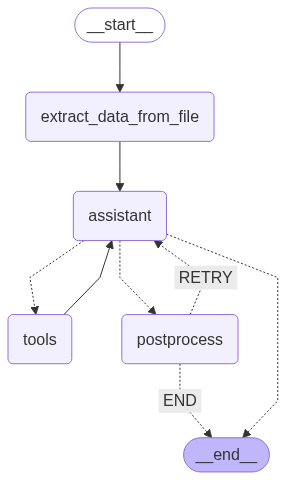

In [ ]:
agent.draw_graph()

# Thank you for your time! 😀
<img src="https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit4/congrats.png">